## 导入数据

In [2]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [29]:
DATA_FILENAME = './2hours.csv'
acc_all = pd.read_csv(DATA_FILENAME)
acc_labels = acc_all['accident num']
acc = acc_all.copy()
acc.drop(['accident num'],axis=1,inplace=True)
# 时间列不需要，sequence序列可表示时间
acc.drop(['Time'],axis=1,inplace=True)
print(acc_all.shape)
print(acc.shape)

(17532, 12)
(17532, 10)


## 数据预处理

In [30]:
cat_attributes = acc.columns[[1]]
time_attributes = acc.columns[[0]]
num_attributes = acc.columns[[n for n in range(2,acc.shape[1])]]
print(cat_attributes)
print(time_attributes)
print(num_attributes)

Index(['holiday'], dtype='object')
Index(['accident type'], dtype='object')
Index(['precipitation', 'visibility', 'wind', 'wind direction', 'fog', 'rain',
       'sun rise', 'sun set'],
      dtype='object')


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime, date, time

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.attribute_names].values

class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        print("debug:fit_transform len(x)=%d"%(len(X)))
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

class TimeAttribsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,time_from='01/01/2011 00:00'):
        self.from_dt = datetime.strptime(time_from, "%d/%m/%Y %H:%M")
    def fit(self,x, y=None):
        return self
    def __do_transform__(self, timeStr):
        #return timeStr
        day_time_splits = timeStr.split(' ')
        dt_format = "%d/%m/%Y %H:%M" if len(day_time_splits[0]) > len(day_time_splits[1]) else "%H:%M %d/%m/%Y"
        dt = datetime.strptime(timeStr, dt_format)
        dt_delta = dt-self.from_dt
        #hours = dt_delta.days*24+dt_delta.seconds/3600
        # 只关注小时时间
        hours= dt_delta.seconds/3600
        return hours/2
    def transform(self,x,y=None):
        # hours from 2000/1/1 0:00
        time_sequence = np.array([self.__do_transform__(str(val[0])) for val in x])
        return np.c_[time_sequence]    

In [32]:
from sklearn.pipeline import Pipeline

# 时间类数据处理
time_pipeline = Pipeline([
    # 数据选择
    ('selector', DataFrameSelector(time_attributes)),
     # 数据选择
    ('time_transformer', TimeAttribsTransformer())
])

# 分类型数据处理num_attributes
cat_pipeline = Pipeline([    
    # 数据选择
    ('selector', DataFrameSelector(cat_attributes)),
    # 分类值独热编码
    ('label_binarizer', LabelBinarizerPipelineFriendly())
])

num_pipeline = Pipeline([
    # 数据选择
    ('selector', DataFrameSelector(num_attributes)),
    # 标准化：标准差标准化
    ('scaler', StandardScaler())
])

# pipeline集合
full_pipelines = FeatureUnion([
    ('num_pipeline',num_pipeline),
    ('cat_pipeline',cat_pipeline),
    #('time_pipeline',time_pipeline)
])


In [33]:
# 准备输入数据
acc_prepared = full_pipelines.fit_transform(acc)
print(acc_prepared.shape)
print(acc_labels.value_counts())
print(acc_prepared[0:4])

debug:fit_transform len(x)=17532
(17532, 9)
0    16219
1     1212
2       98
3        3
Name: accident num, dtype: int64
[[-0.06465394  0.2651457   1.15043477 -0.21958904 -0.20362638 -0.27402253
  -0.30910287 -0.31427953  1.        ]
 [-0.06465394  0.2651457   0.05587862 -0.21958904 -0.20362638 -0.27402253
  -0.30910287 -0.31427953  1.        ]
 [-0.06465394  0.2651457   0.71070873 -0.21958904 -0.20362638 -0.27402253
  -0.30910287 -0.31427953  1.        ]
 [-0.06465394  0.2651457   1.15043477 -0.21958904 -0.20362638 -0.27402253
   3.23516891 -0.31427953  1.        ]]


In [34]:
# 准备输出数据，分类任务，使用独热编码
print(acc_labels.value_counts())
label_pipeline = Pipeline([
    ('label_binarizer', LabelBinarizerPipelineFriendly())    
])
acc_labels_1hot = label_pipeline.fit_transform(acc_labels)
print(acc_labels_1hot.shape)

0    16219
1     1212
2       98
3        3
Name: accident num, dtype: int64
debug:fit_transform len(x)=17532
(17532, 4)


## 使用Tensorflow描述RNN网络

In [35]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

import time

print(tf.__version__)

1.9.0


In [1]:
data_x = acc_prepared[:acc_prepared.shape[0],]
print(data_x.shape)

data_y = acc_labels[0:]
print(data_y.shape)

data_y = data_y.values.reshape((-1, 1))
print(data_y.shape)

NameError: name 'acc_prepared' is not defined

In [17]:
print(data_y[0:10])

[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [37]:
arr = np.where(data_y[:,0]==2)
arr[0]

array([  560,  1066,  1158,  1183,  3609,  4472,  4578,  6039,  6097,
        6882,  6900,  7388,  7558,  7904,  7951,  8147,  8439,  9009,
        9196,  9198,  9379,  9915,  9963, 10124, 10131, 10278, 10304,
       10975, 11337, 11547, 11559, 11677, 11907, 11958, 11971, 11982,
       11995, 12006, 12178, 12291, 12505, 12512, 12656, 12785, 12812,
       12964, 12976, 12999, 13104, 13136, 13201, 13229, 13232, 13662,
       13686, 13830, 13878, 13928, 13941, 13973, 13986, 13998, 14150,
       14234, 14333, 14490, 14503, 14644, 14669, 14827, 14852, 14980,
       15151, 15235, 15429, 15810, 15907, 16016, 16094, 16182, 16204,
       16241, 16287, 16323, 16375, 16695, 16696, 16726, 16728, 16875,
       16879, 16968, 17048, 17051, 17309, 17345, 17492, 17515])

### 准备小批量数据

In [91]:
"""
生成随机批量训练数据。由于labels分布不均，手动调整数据采样密度
"""
def batch_generator(x, y, batch_size, sequence_length, splits=[0.4,0.7,0.95,1.0], y_labels=[0,1,2,3]):
    x_rows = x.shape[0]
    x_cols = x.shape[1]
    y_cols = len(y_labels)

    index_arrays = []
    for i in range(y_cols):
        arr = np.where(y[:,0]==i)
        #print(i,"arr_len", len(arr[0]))
        index_arrays.append(arr[0])
    #print(index_arrays)
    while True:
        x_shape = (batch_size, sequence_length, x_cols)
        x_batch = np.zeros(shape=x_shape, dtype=np.float32)

        y_shape = (batch_size, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float32)
        
        end_idx = 0
        
        for i in range(batch_size):
            '''
            end_idx = np.random.randint(sequence_length-1, x_rows)
            '''
            end_idx = 0
            while True:
                num = np.random.randint(0, 100)
                label = 0                    
                if num >= 0 and num < splits[0]*100:
                    label = 0
                elif num >= splits[0]*100 and num < splits[1]*100:
                    label = 1
                elif num >= splits[1]*100 and num < splits[2]*100:
                    label = 2
                else:
                    label = 3

                if len(index_arrays[label]) == 0:
                    end_idx = np.random.randint(sequence_length-1, x_rows)
                else:
                    index_idx = np.random.randint(0, len(index_arrays[label]))
                    end_idx = index_arrays[label][index_idx]

                if end_idx < sequence_length-1:
                    continue
                else:
                    break
            #'''  
            x_batch[i] = x[end_idx-(sequence_length-1): end_idx+1]
            y_batch[i] = y[end_idx]

        yield x_batch, y_batch

In [76]:
if False:
    array = np.array(range(acc.shape[0]))
    acc['index'] = pd.Series(array, index=acc.index)
    acc.head()

    test_attributes = acc.columns[[-1,5]]
    generator_test = batch_generator(x=acc[test_attributes], y=data_y, batch_size=4, sequence_length=16)
    for x_batch, y_batch in generator_test:
        print(y_batch.shape)
        for i in range(4):
            print(x_batch[i], y_batch[i])
        break

### 定义RNN结构
使用tensorflow来描述RNN网络。RNN一般有四种组织结构，如下图所示。交通数据模型选定为第2种模型seq-to-vector模型，第1种seq-to-seq模型也比较合理。
![](./rnn-model-types.png)

In [77]:
def graph_reset(sess=None):
    if sess != None: 
        sess.close()
    tf.reset_default_graph()

In [113]:
# define the rnn configs
n_inputs = data_x.shape[1]
n_outputs = data_y.shape[1]
cell_type = 'LSTM'
n_batch = 32
n_neurons = 64
# 24*2 = 48hours
n_steps = 24
n_layers = 4
dropout_in = False
dropout_out = False
dropout_prob_in = 0.5
dropout_prob_out = 0.5
n_train_steps = 1024
# 先使用较大学习速率，再使用较小学习完成收殓
learning_rate_init = 1e-3
learning_rate_decayed = 1e-5
accuracy_max = 0.95
# Default: tanh
activation=tf.nn.tanh #relu
train_all = True

configs = {
    'learning_rate_init':learning_rate_init,
    'learning_rate_decayed':learning_rate_decayed,
    'n_train_steps':n_train_steps,
    'n_steps':n_steps,
    'n_batch':n_batch,
    'n_outputs':n_outputs,
    'n_inputs':n_inputs,
    'accuracy_max':accuracy_max
}
print(configs)

{'learning_rate_init': 0.001, 'learning_rate_decayed': 1e-05, 'n_train_steps': 1024, 'n_steps': 24, 'n_batch': 32, 'n_outputs': 1, 'n_inputs': 9, 'accuracy_max': 0.95}


#### RNN模型

```
- rnn: n_neurons  
- x: (n_batch, n_steps, n_inputs)  
- y: (n_batch, n_outputs)
- W: (n_nuerons, n_outputs)  
- b: (n_outputs)  
- x => RNN => outputs(n_batch, n_steps, n_neurons)
- outputs => stacked_output(n_batch*n_steps, n_neurons)
- stacked_output * W + b => (n_batch*n_steps, n_outputs) => (n_batch, n_steps, n_outputs)
- logits_unstacked: (n_batch, n_steps, n_outputs) => (n_steps, n_batch, n_outputs)
- logits: logits_unstacked[-1] => (n_batch, n_outputs)
- loss: mean_reduce(logits, y)
```

In [114]:
graph_reset()

t = time.time()

learning_rate = tf.placeholder(tf.float32, shape=[])

# seq to seq vector model
x = tf.placeholder(tf.float32, [n_batch, n_steps, n_inputs], name="x_placeholder")
y = tf.placeholder(tf.float32, [n_batch, n_outputs], name="y_placeholder")
print("x shape", x.shape)
print("y shape", y.shape)


stacked_cells = []
for i in range(n_layers):
    cell = None
    if cell_type == 'GRU':
        cell = tf.contrib.rnn.GRUCell(n_neurons)
    elif cell_type == 'LSTM':
        cell = tf.contrib.rnn.LSTMCell(n_neurons, state_is_tuple=True)
    else:
        cell = tf.contrib.rnn.BasicRNNCell(n_neurons)
    if dropout_in:
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=dropout_prob_in)
    if dropout_out:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=dropout_prob_out)

    # add full-connect layer with OutputProjectionWrapper
    # cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=n_outputs)
    stacked_cells.append(cell)

rnn_cells = tf.contrib.rnn.MultiRNNCell(stacked_cells)
#rnn_cells = tf.contrib.rnn.MultiRNNCell(stacked_cells, state_is_tuple=cell_type == 'LSTM')
outputs, states = tf.nn.dynamic_rnn(rnn_cells, x, dtype=tf.float32)
print("outputs shape", outputs.shape)

# fully-connected layer
W = tf.get_variable('W', [ n_neurons, n_outputs], initializer=tf.constant_initializer(0.0))
b = tf.get_variable('b', [ n_outputs], initializer=tf.constant_initializer(0.0))
print("W shape", W.shape)
print("b shape", b.shape)


# shape:(n_batch, n_steps, n_nuerons) => (n_batch*n_steps, n_nuerons)
unstacked_output = tf.reshape(outputs, [-1, n_neurons])
print("unstacked_output shape", unstacked_output.shape)

# unstacked_output(n_batch*n_steps, n_nuerons)
# w(n_nuerons, n_outputs)
# b(n_outputs)
# fully_conn_output(n_batch*n_steps, n_output)
fully_conn_output = tf.matmul(unstacked_output, W) + b
# fully_conn_output(n_batch*n_steps, n_output) => (n_batch, n_steps, n_outputs) 
logits_nsteps = tf.reshape(fully_conn_output, [-1, n_steps, n_outputs])
# logits_nsteps(n_batch, n_steps, n_outputs) => logits_nsteps n_steps*(n_batch, n_outputs) 
logits_unstacked = tf.unstack(logits_nsteps, n_steps, 1)
# logits = tf.cast(logits_unstacked[-1], tf.int32)
logits = logits_unstacked[-1]
print("logits shape", logits.shape)

logits_1d = tf.reshape(logits,[-1])
y_1d = tf.reshape(y,[-1])

#loss_step = tf.losses.mean_squared_error(predictions=logits,labels=y)
loss_step = tf.reduce_mean(tf.square(logits_1d - y_1d))
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_step)  
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_step)

# accuracy
predictions = tf.cast(logits[-1]+0.5, tf.int32)
y_cast = tf.cast(y, tf.int32)
correct_predict = tf.equal(predictions, y_cast)
accuracy_step = tf.reduce_mean(tf.cast(correct_predict, tf.float32))

print("create rnn network within", time.time() - t, "seconds")

x shape (32, 24, 9)
y shape (32, 1)
outputs shape (32, 24, 64)
W shape (64, 1)
b shape (1,)
unstacked_output shape (768, 64)
logits shape (32, 1)
create rnn network within 1.636871337890625 seconds


### 训练模型

In [111]:
data_xx = acc_prepared
data_yy = acc_labels.values.reshape((-1, 1))

x_batch shape (32, 24, 9)
Step 1, Mini-batch Loss= 1.6851, accuracy=0.3438
Step 32, Mini-batch Loss= 1.0134, accuracy=0.2188
Step 64, Mini-batch Loss= 0.7626, accuracy=0.3438
Step 96, Mini-batch Loss= 0.8181, accuracy=0.2812
Step 128, Mini-batch Loss= 0.8054, accuracy=0.3750
Step 160, Mini-batch Loss= 0.7802, accuracy=0.2500
Step 192, Mini-batch Loss= 0.7338, accuracy=0.3438
Step 224, Mini-batch Loss= 0.7790, accuracy=0.3125
Step 256, Mini-batch Loss= 0.9755, accuracy=0.2812
Step 288, Mini-batch Loss= 0.5261, accuracy=0.3125
Step 320, Mini-batch Loss= 0.7616, accuracy=0.2188
Step 352, Mini-batch Loss= 0.7179, accuracy=0.3125
Step 384, Mini-batch Loss= 0.6798, accuracy=0.2500
Step 416, Mini-batch Loss= 0.5393, accuracy=0.2500
Step 448, Mini-batch Loss= 0.5473, accuracy=0.2500
Step 480, Mini-batch Loss= 0.4647, accuracy=0.3750
Step 512, Mini-batch Loss= 0.4890, accuracy=0.1875
Step 544, Mini-batch Loss= 0.8709, accuracy=0.2812
Step 576, Mini-batch Loss= 0.6602, accuracy=0.2500
Step 608, 

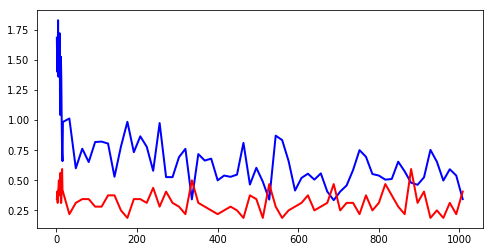

In [115]:
import matplotlib

if train_all:
    generator = batch_generator(x=data_x,
                                y=data_y, 
                                batch_size = n_batch, 
                                sequence_length = n_steps)
    
    init = tf.global_variables_initializer()
    step = 0
    train_record = {
        'step':[],
        'loss':[],
        'accuracy':[]
    }
    with tf.Session() as sess:
        step_display = 32
        step_statistics = 16

        sess.run(init)
        for x_batch, y_batch in generator:
            #print('x_batch',x_batch)
            #print('y_batch',y_batch)
            
            step=step+1
            if(step >= n_train_steps):
                print("training @steps",n_train_steps,",stop it")
                break
            if step == 1:
                print("x_batch shape", x_batch.shape)
            sess.run(train_step, feed_dict={
                x:x_batch, 
                y:y_batch, 
                learning_rate:learning_rate_init if step<(n_train_steps/2) else learning_rate_decayed})
            
            # debug step == 1:
            if step < 1:
                s_fully_conn_output, s_logits = sess.run([fully_conn_output,
                                                                                  logits], 
                                                                                  feed_dict={x:x_batch, y:y_batch})
                print(s_fully_conn_output[0:36])
                print(s_logits[0:6])


            if step % step_statistics == 0 or step < 16:
                loss,accuracy = sess.run([loss_step,accuracy_step], feed_dict={x:x_batch, y:y_batch})
                train_record['step'].append(step)
                train_record['loss'].append(loss)
                train_record['accuracy'].append(accuracy)

                if step % step_display == 0 or step == 1:
                    print("Step " + str(step) + ", Mini-batch Loss= " + \
                          "{:.4f}".format(loss) + ", accuracy=" + \
                          "{:.4f}".format(accuracy))
                
                if step < 16:
                    logits_unstacked_res, logist_1d_res, y_1d_res = sess.run([logits_unstacked,logits_1d,y_1d],
                                           feed_dict={x:x_batch, y:y_batch})
                    #print(logits_unstacked_res)
                    #print(logist_1d_res)
                    #print(y_1d_res)
                


    # plot result
    matplotlib.rc('figure', figsize=(8,4))
    plt.plot(train_record['step'], train_record['loss'], linewidth=2, color='blue')
    plt.plot(train_record['step'], train_record['accuracy'], linewidth=2, color='red')
    print("Optimization Finished!")

### 交叉验证

In [21]:
def train_validate(sess, model, train_generator, val_generator, configs):
    step = 0
    step_display = 64
    step_statistics = 8
    train_record = {
      'step':[],
      'loss':[],
      'accuracy':[]
    }
    accuracy = 0.0
    loss = 0.0
    accuracy_counter = 0

    init = tf.global_variables_initializer()
    sess.run(init)

    # train steps
    for x_batch, y_batch in train_generator:
        step=step+1
        if(step >= configs['n_train_steps']):
            break
    
        my_learning_rate = configs['learning_rate_init']
        if step > (configs['n_train_steps']/2):
            my_learning_rate = configs['learning_rate_decayed']

        sess.run(model['train_step'], feed_dict={
            x : x_batch, 
            y : y_batch, 
            learning_rate : my_learning_rate })
        
        accuracy = sess.run(model['accuracy_step'], feed_dict={x:x_batch, y:y_batch})
        if(accuracy > configs['accuracy_max']):
            accuracy_counter += 1
            #print("Step ",step, "accuracy_counter ", accuracy_counter ,", accuracy:",accuracy)
        else:
            accuracy_counter = 0
        if accuracy_counter >= 8:
            break

        if step % step_statistics == 0 or step < 16:
            loss = sess.run(model['loss_step'], feed_dict={x:x_batch, y:y_batch})
            train_record['step'].append(step)
            train_record['loss'].append(loss)
            train_record['accuracy'].append(accuracy)
            if step % step_display == 0 or step == 1:
                print("Step " + str(step) + ", Mini-batch Loss= " + \
                      "{:.4f}".format(loss) + ", accuracy=" + \
                      "{:.4f}".format(accuracy))
    # cross validate
    for x_batch, y_batch in val_generator:
        loss,accuracy = sess.run([model['loss_step'],model['accuracy_step']],
                                                   feed_dict={x:x_batch, y:y_batch})
        print("cross validate accuracy:",accuracy, ',loss:',loss)
        break
    
    return train_record, loss, accuracy

In [22]:
from sklearn.model_selection import KFold

def cross_validate(sess, x, y, configs, split_size=4, n_val_steps=128):
    train_records = []
    cv_loss_records = []
    cv_accuracy_records = []
    
    # k-fold split
    kf = KFold(n_splits=split_size)
    for train_idx, val_idx in kf.split(x, y):
        train_x = x[train_idx]
        train_y = y[train_idx]
        val_x = x[val_idx]
        val_y = y[val_idx]

        train_generator = batch_generator(x=train_x, 
                                            y=train_y, 
                                            batch_size=configs['n_batch'], 
                                            sequence_length=configs['n_steps'])
        val_generator = batch_generator(x=val_x, 
                            y=val_y, 
                            batch_size=configs['n_batch']*2, 
                            sequence_length=configs['n_steps'])
        model = {
            'train_step':train_step,
            'loss_step':loss_step,
            'accuracy_step':accuracy_step
        }
        
        train_record, loss, accuracy = train_validate(
            sess=sess,
            model=model, 
            train_generator=train_generator, 
            val_generator=val_generator, 
            configs=configs
        )
        train_records.append(train_record)
        cv_accuracy_records.append(accuracy)
        cv_loss_records.append(loss)
        
        # REMOVE ME:暂时只使用一个集合训练
        break
    
    return train_records, cv_loss_records, cv_accuracy_records

In [23]:
sess = tf.Session()
train_records, cv_loss_records, cv_accuracy_records = cross_validate(
    sess, x=data_x, y=data_y, configs=configs, split_size=4
)
print("train and cross-validate done")

Step 1, Mini-batch Loss= 1.6263, accuracy=0.4375
Step 64, Mini-batch Loss= 0.7739, accuracy=0.4062
Step 128, Mini-batch Loss= 1.0380, accuracy=0.1875
Step 192, Mini-batch Loss= 0.7569, accuracy=0.2188
Step 256, Mini-batch Loss= 0.5641, accuracy=0.4062
Step 320, Mini-batch Loss= 0.7614, accuracy=0.2500
Step 384, Mini-batch Loss= 0.6194, accuracy=0.3750
Step 448, Mini-batch Loss= 0.9839, accuracy=0.0938
Step 512, Mini-batch Loss= 0.8535, accuracy=0.2188
Step 576, Mini-batch Loss= 0.8562, accuracy=0.1875
Step 640, Mini-batch Loss= 0.7501, accuracy=0.3438
Step 704, Mini-batch Loss= 0.7540, accuracy=0.2812
Step 768, Mini-batch Loss= 0.7007, accuracy=0.2500
Step 832, Mini-batch Loss= 0.7939, accuracy=0.2500
Step 896, Mini-batch Loss= 0.6351, accuracy=0.2500
Step 960, Mini-batch Loss= 0.7439, accuracy=0.3438
cross validate accuracy: 0.25 ,loss: 0.7202111
train and cross-validate done


[0.25]


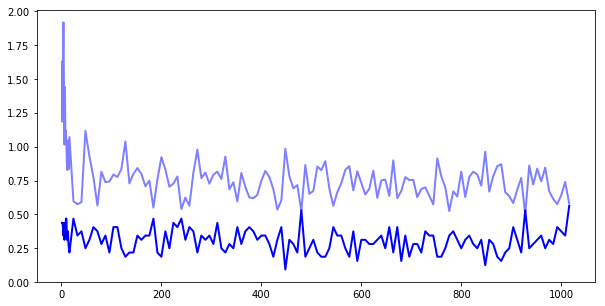

In [24]:
import matplotlib

matplotlib.rc('figure', figsize=(10,5))
colors=['blue','red','gray','green']
color_idx = 0
for train_record in train_records:
    plt.plot(train_record['step'], train_record['loss'], linewidth=2, color=colors[color_idx], alpha=0.5)
    plt.plot(train_record['step'], train_record['accuracy'], linewidth=2, color=colors[color_idx])
    color_idx+=1

# cross-validate accuracy result
print(cv_accuracy_records)